In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
# Load the datasets
patients_df = pd.read_csv('cleaned_PATIENTS.csv')
admissions_df = pd.read_csv('cleaned_ADMISSIONS.csv')

   ROW_ID  SUBJECT_ID GENDER         DOB         DOD             DOD_HOSP  \
0     234         249      F  2075-03-13         NaN                  NaN   
1     235         250      F  2164-12-27  2188-11-22  2188-11-22 00:00:00   
2     236         251      M  2090-03-15         NaN                  NaN   
3     237         252      M  2078-03-06         NaN                  NaN   
4     238         253      F  2089-11-26         NaN                  NaN   

  DOD_SSN  EXPIRE_FLAG  
0     NaN            0  
1     NaN            1  
2     NaN            0  
3     NaN            0  
4     NaN            0  
   ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      

In [4]:
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaN,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaN,NaN,NaN,0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0


In [5]:
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_LOCATION,DISCHARGE_LOCATION,EDREGTIME,EDOUTTIME,...,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,2196-04-09 10:06:00,2196-04-09 13:24:00,...,False,False,False,False,False,True,False,False,False,False
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,TRANSFER FROM HOSP/EXTRAM,HOME,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY ROOM ADMIT,HOME,2160-11-02 01:01:00,2160-11-02 04:27:00,...,False,False,False,False,False,True,False,False,False,False


In [29]:
# Identifying one-hot encoded columns for each category
ethnicity_cols = [col for col in admissions_df.columns if col.startswith('ETHNICITY_')]
religion_cols = [col for col in admissions_df.columns if col.startswith('RELIGION_')]
language_cols = [col for col in admissions_df.columns if col.startswith('LANGUAGE_')]

# For merging, select only the first occurrence since the aim is to avoid multiple entries but keep one-hot encoding
first_admissions_entry = admissions_df.groupby('SUBJECT_ID').head(1)

# Merging the first entry of admissions data with the patients data
merged_df = pd.merge(patients_df[['SUBJECT_ID', 'EXPIRE_FLAG']], first_admissions_entry, on='SUBJECT_ID')

# To check for changes in one-hot encoded columns, we sum across rows for each category in the original admissions_df_new
# This will give a count of how many times each category was marked for each patient
sum_ethnicity = admissions_df.groupby('SUBJECT_ID')[ethnicity_cols].sum()
sum_religion = admissions_df.groupby('SUBJECT_ID')[religion_cols].sum()
sum_language = admissions_df.groupby('SUBJECT_ID')[language_cols].sum()

# A patient has changed their info if the sum in any category column is > 1
changes_ethnicity = sum_ethnicity[sum_ethnicity > 1].dropna(how='all')
changes_religion = sum_religion[sum_religion > 1].dropna(how='all')
changes_language = sum_language[sum_language > 1].dropna(how='all')

# Number of patients with changes
num_changes = {
    'Ethnicity Changes': changes_ethnicity.shape[0],
    'Religion Changes': changes_religion.shape[0],
    'Language Changes': changes_language.shape[0]
}

# Displaying the merged dataframe and the number of changes
merged_df.head(), num_changes

(   SUBJECT_ID  EXPIRE_FLAG  ROW_ID  HADM_ID            ADMITTIME  \
 0         249            0     321   116935  2149-12-17 20:41:00   
 1         250            1     324   124271  2188-11-12 09:22:00   
 2         251            0     325   117937  2110-07-27 06:46:00   
 3         252            0     326   190159  2133-03-31 04:24:00   
 4         253            0     328   176189  2174-01-21 20:58:00   
 
              DISCHTIME            DEATHTIME         ADMISSION_LOCATION  \
 0  2149-12-31 14:55:00                  NaN       EMERGENCY ROOM ADMIT   
 1  2188-11-22 12:00:00  2188-11-22 12:00:00       EMERGENCY ROOM ADMIT   
 2  2110-07-29 15:23:00                  NaN       EMERGENCY ROOM ADMIT   
 3  2133-04-23 15:00:00                  NaN       EMERGENCY ROOM ADMIT   
 4  2174-01-26 16:15:00                  NaN  TRANSFER FROM HOSP/EXTRAM   
 
          DISCHARGE_LOCATION            EDREGTIME  ...  \
 0                       SNF  2149-12-17 11:10:00  ...   
 1              

In [31]:
# merged df now only has patients that did not change their categorical variables within multiple admissions to the hospital. 
merged_df.shape

(46520, 163)

In [32]:
merged_df.isna().sum()

SUBJECT_ID                            0
EXPIRE_FLAG                           0
ROW_ID                                0
HADM_ID                               0
ADMITTIME                             0
                                     ..
ETHNICITY_WHITE                       0
ETHNICITY_WHITE - BRAZILIAN           0
ETHNICITY_WHITE - EASTERN EUROPEAN    0
ETHNICITY_WHITE - OTHER EUROPEAN      0
ETHNICITY_WHITE - RUSSIAN             0
Length: 163, dtype: int64

In [33]:
ethnicity_columns = [col for col in merged_df.columns if 'ETHNICITY_' in col]
religion_columns = [col for col in merged_df.columns if 'RELIGION_' in col]
language_columns = [col for col in merged_df.columns if 'LANGUAGE_' in col]

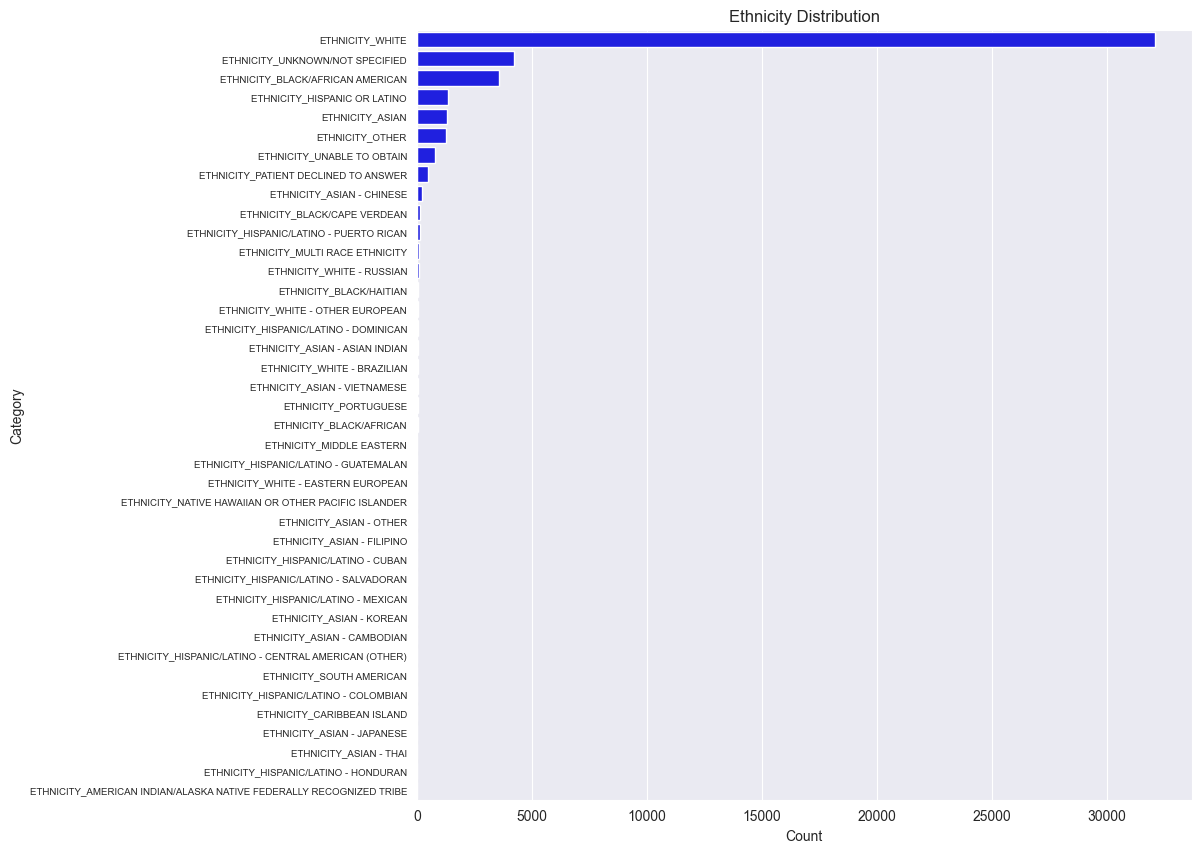

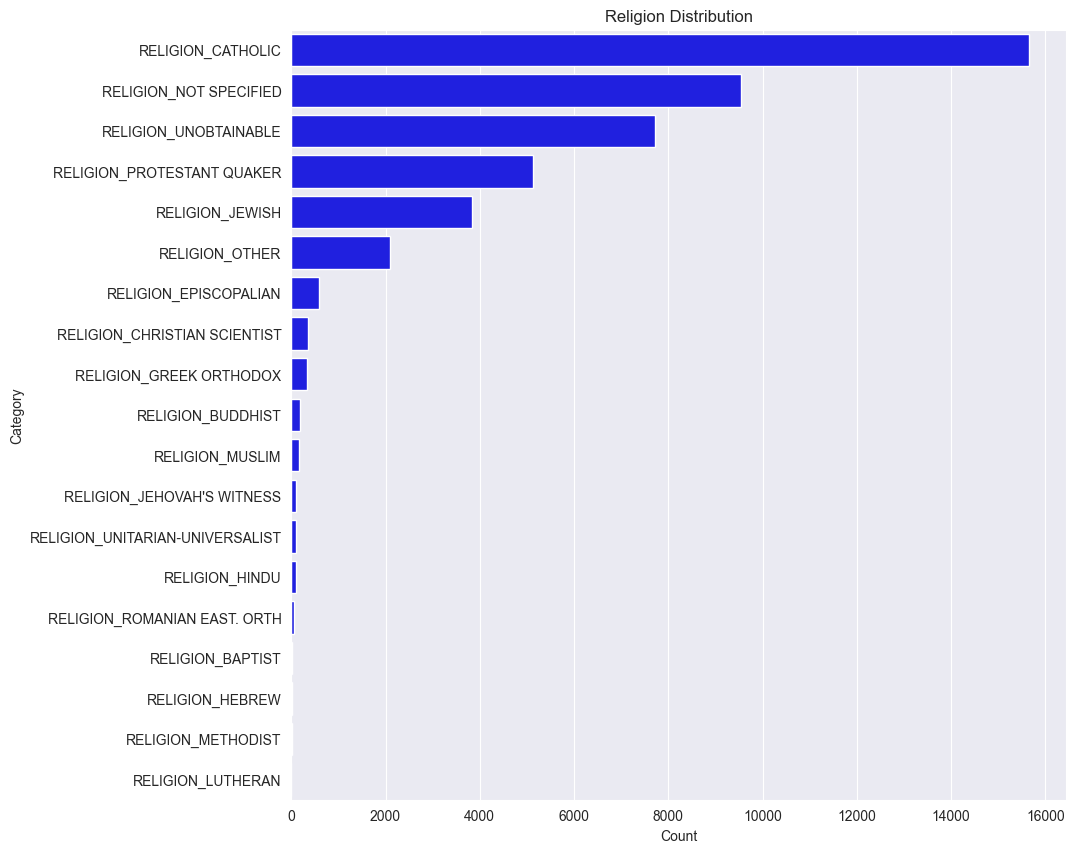

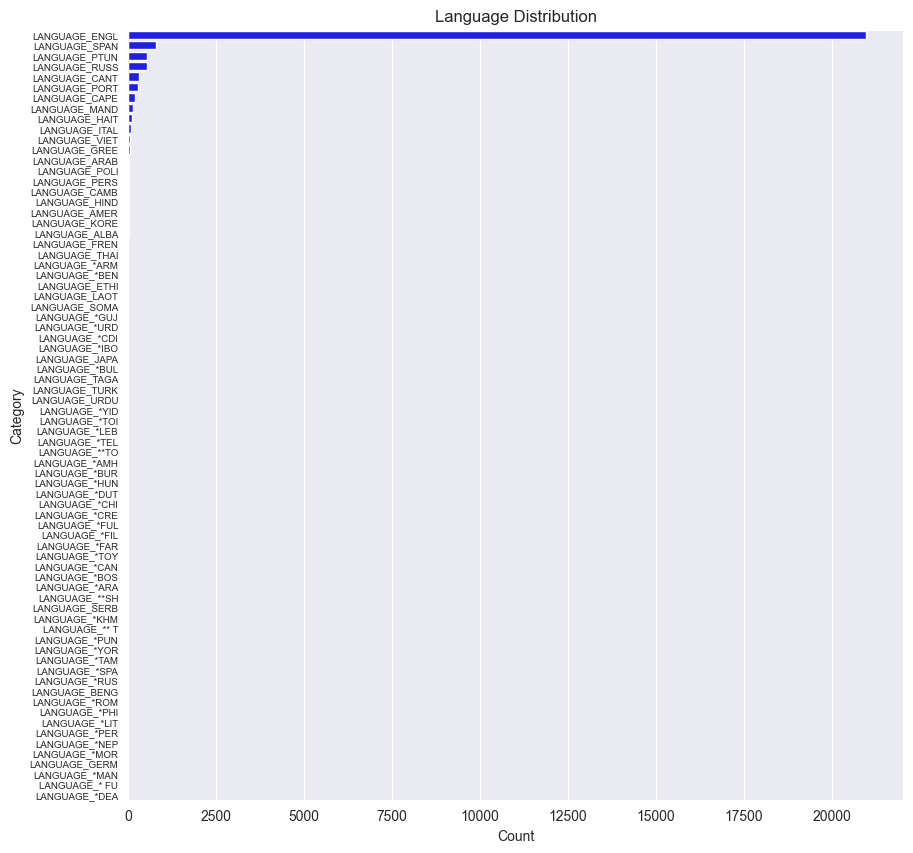

In [34]:
# Creating a function to plot distributions for given columns
def plot_demographic_distribution(columns, title, font_size):
    # Summing up the counts for each demographic category
    demographic_counts = merged_df[columns].sum().sort_values(ascending=False)
    # Plot
    plt.figure(figsize=(10, 10))
    barplot = sns.barplot(x=demographic_counts.values, y=demographic_counts.index, color="blue")
    plt.title(title)
    plt.xlabel('Count')
    plt.yticks(fontsize=font_size) 
    plt.ylabel('Category')
    plt.show()

# Plotting for each demographic
plot_demographic_distribution(ethnicity_columns, 'Ethnicity Distribution', 7)
plot_demographic_distribution(religion_columns, 'Religion Distribution', 10)
plot_demographic_distribution(language_columns, 'Language Distribution', 7)

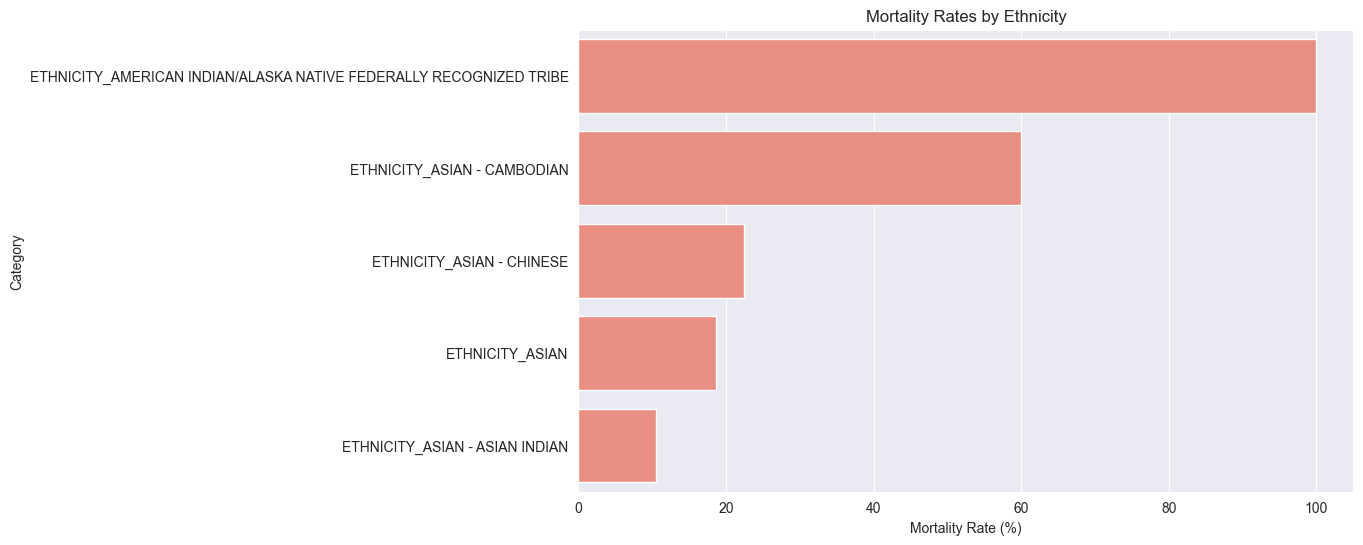

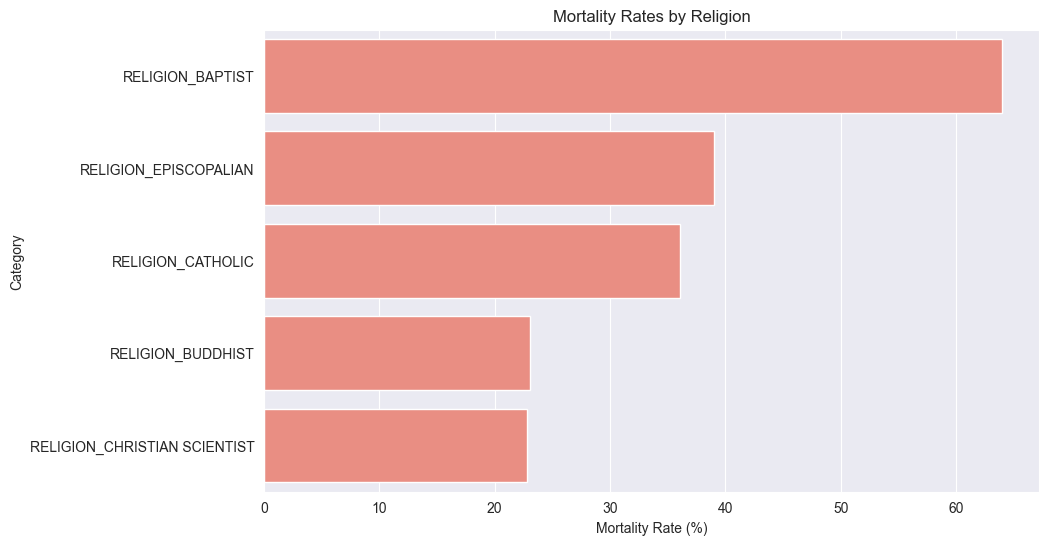

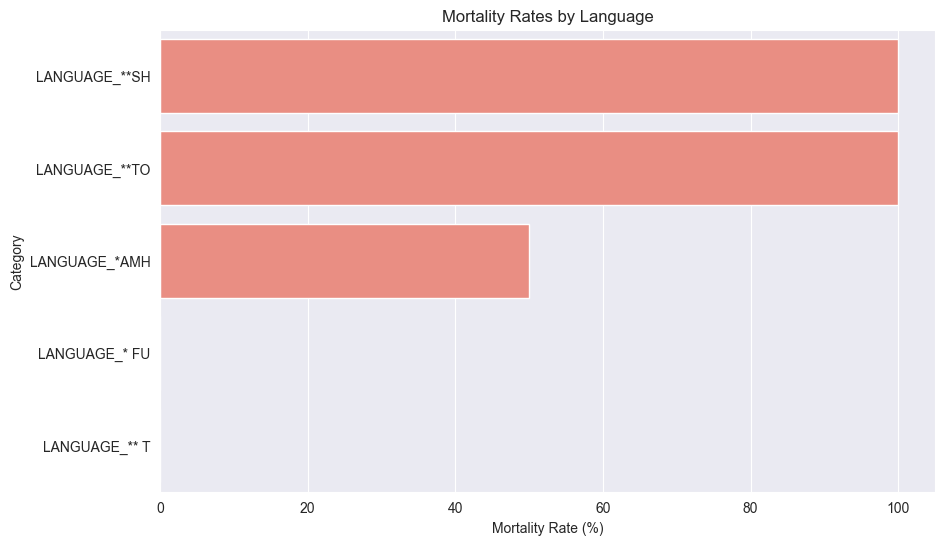

In [36]:
def plot_mortality_rates_corrected(columns, title):
    mortality_rates = {}
    for col in columns:
        group_mean = merged_df.groupby(col)['EXPIRE_FLAG'].mean()
        if len(group_mean) > 1:  # Ensure there are at least two groups (0 and 1 for the demographic variable)
            mortality_rate = group_mean.loc[True] * 100  # Specifically use .loc[True] to avoid indexing issues
        else:
            mortality_rate = 0  # Default to 0 if there's no variation in the group
        mortality_rates[col] = mortality_rate
    
    # Sorting the mortality rates for plotting
    mortality_rates_sorted = {k: v for k, v in sorted(mortality_rates.items(), key=lambda item: item[1], reverse=True)}
    
    # Creating the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(mortality_rates_sorted.values()), y=list(mortality_rates_sorted.keys()), color="salmon")
    plt.title(f'Mortality Rates by {title}')
    plt.xlabel('Mortality Rate (%)')
    plt.ylabel('Category')
    plt.show()


# Each bar represents the mortality rate (%) within the respective category.
plot_mortality_rates_corrected(ethnicity_columns[:5], 'Ethnicity') 
plot_mortality_rates_corrected(religion_columns[:5], 'Religion')
plot_mortality_rates_corrected(language_columns[:5], 'Language')

# chi-square test 
For each categorical variable (e.g., ethnicity, religion, language), a contingency table is created comparing the counts of outcomes (in this case, mortality indicated by EXPIRE_FLAG) across the categories of that variable. This table provides a summary of the observed frequencies of mortality (alive or deceased) within each group. `table = pd.crosstab(merged_df[col], merged_df['EXPIRE_FLAG'])`

The chi-square test calculates a statistic that measures the difference between the observed frequencies in each category and the frequencies that would be expected if there was no association between the categorical variable and mortality. The formula for the chi-square statistic involves summing the squared difference between observed and expected frequencies, divided by the expected frequencies: $\Chi ^2 = \Sigma\frac{(O-E)^2}{E}$


## Interpreting it

Chi-square statistic $(\Chi ^2)$: A higher value indicates a greater difference between observed and expected frequencies, suggesting a stronger association between the categorical variable and mortality rates.
 
A lower p-value (typically less than 0.05) is interpreted as evidence against the null hypothesis (which posits no association), indicating a statistically significant difference in mortality rates across the groups.

In [40]:
# Function to perform chi-square tests for a list of columns
def chi_square_test_for_columns(columns):
    results = {}
    for col in columns:
        # Create a contingency table
        table = pd.crosstab(merged_df[col], merged_df['EXPIRE_FLAG'])
        # Perform the chi-square test
        chi2, p, dof, expected = chi2_contingency(table)
        # Store the results
        results[col] = p
    return results

ethnicity_results = chi_square_test_for_columns(ethnicity_columns) 
religion_results = chi_square_test_for_columns(religion_columns) 
language_results = chi_square_test_for_columns(language_columns) 

ethnicity_results, religion_results, language_results

({'ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 0.21912955876555512,
  'ETHNICITY_ASIAN': 5.895419653000405e-32,
  'ETHNICITY_ASIAN - ASIAN INDIAN': 0.0003345692785096534,
  'ETHNICITY_ASIAN - CAMBODIAN': 0.15807597225690842,
  'ETHNICITY_ASIAN - CHINESE': 0.0003825728826652188,
  'ETHNICITY_ASIAN - FILIPINO': 0.7510842834070975,
  'ETHNICITY_ASIAN - JAPANESE': 1.0,
  'ETHNICITY_ASIAN - KOREAN': 0.43460420560862456,
  'ETHNICITY_ASIAN - OTHER': 0.1589909769784994,
  'ETHNICITY_ASIAN - THAI': 0.5288207715557055,
  'ETHNICITY_ASIAN - VIETNAMESE': 0.147358388091108,
  'ETHNICITY_BLACK/AFRICAN': 0.38190048400599874,
  'ETHNICITY_BLACK/AFRICAN AMERICAN': 9.515429793431836e-11,
  'ETHNICITY_BLACK/CAPE VERDEAN': 0.001154143890126756,
  'ETHNICITY_BLACK/HAITIAN': 0.0037452628801829583,
  'ETHNICITY_CARIBBEAN ISLAND': 0.13503875577172567,
  'ETHNICITY_HISPANIC OR LATINO': 1.381750460763406e-29,
  'ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 0.699077282820143,


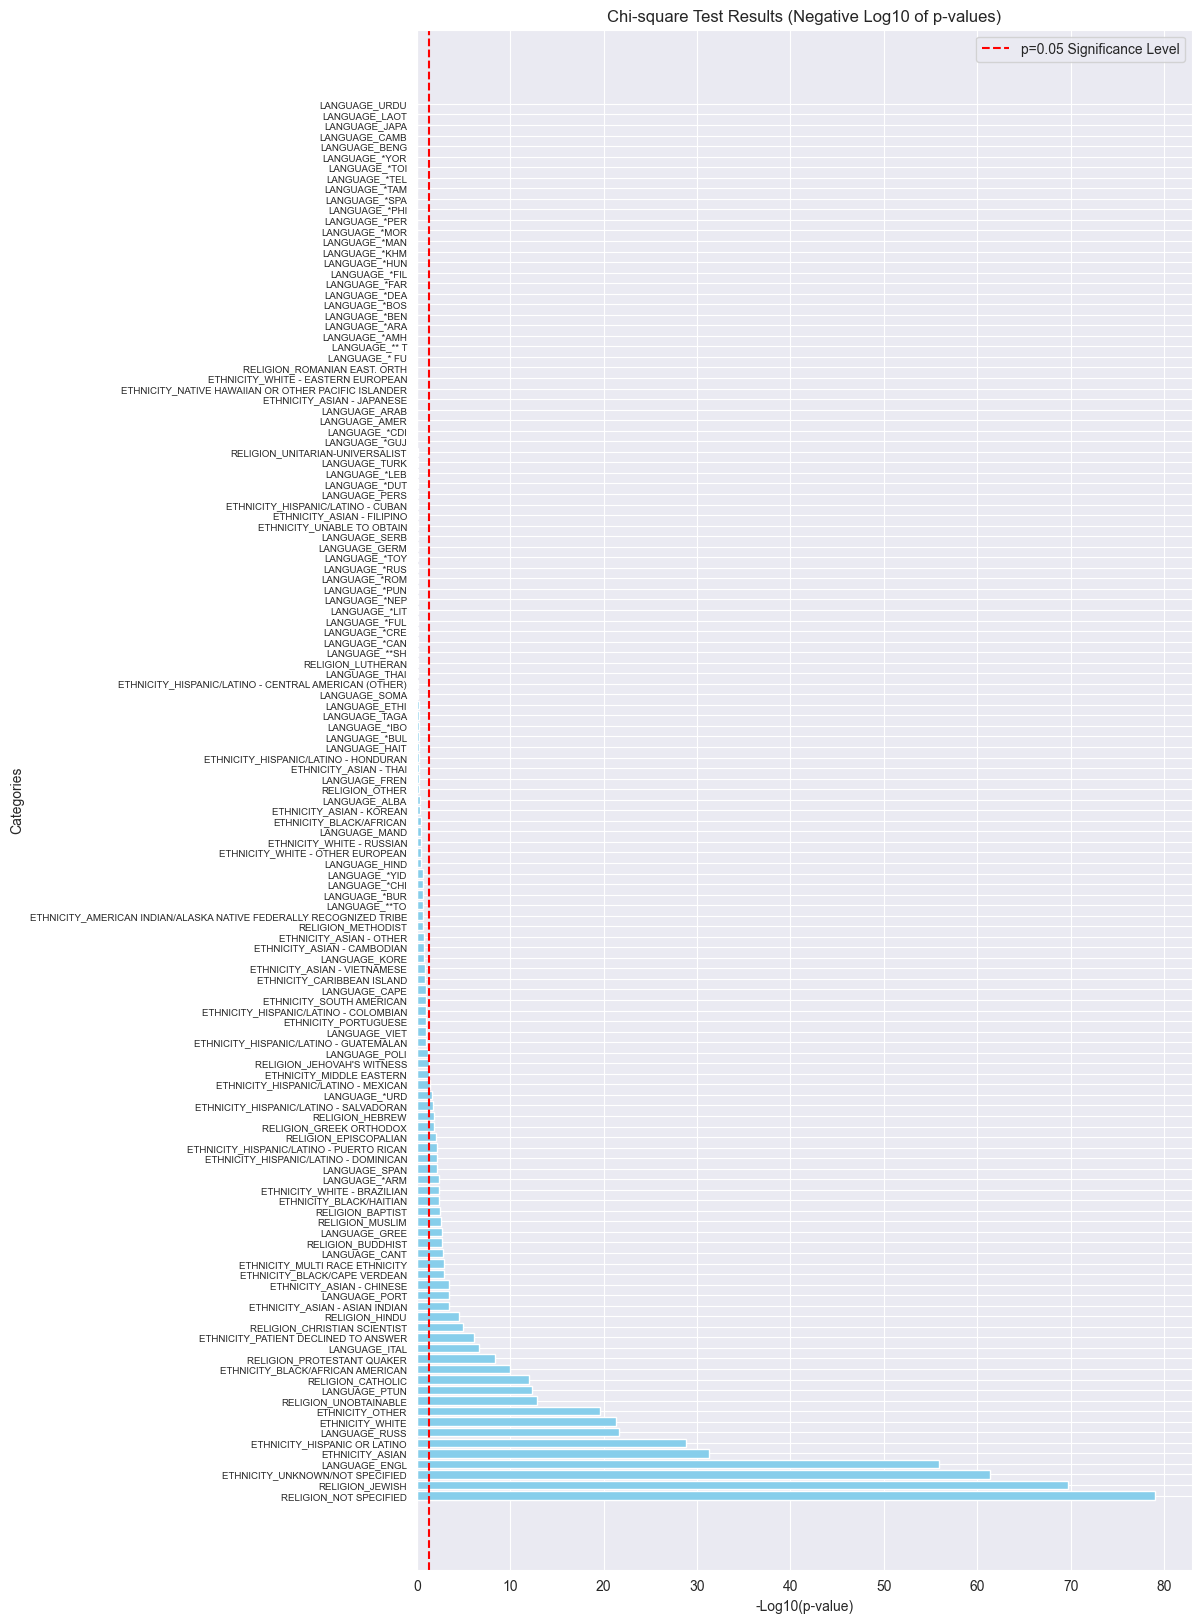

In [46]:
# Combine the results into a single dictionary for easier plotting
chi_square_results = {
    **ethnicity_results,
    **religion_results,
    **language_results
}

# Transform the p-values using negative logarithm to emphasize differences
# Add a small value to avoid taking log(0) which is undefined
log_p_values = {k: -np.log10(v + 1e-100) for k, v in chi_square_results.items()}

# Sorting results for better visualization
sorted_categories = sorted(log_p_values.keys(), key=lambda x: log_p_values[x], reverse=True)

# Plotting
plt.figure(figsize=(10, 20))
plt.barh(sorted_categories, [log_p_values[category] for category in sorted_categories], color='skyblue')
plt.xlabel('-Log10(p-value)')
plt.ylabel('Categories')
plt.yticks(fontsize=7)

plt.title('Chi-square Test Results (Negative Log10 of p-values)')
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p=0.05 Significance Level')
plt.legend()
plt.show()

In [51]:
# Function to filter and print categories with significant differences (p < 0.05)
def print_significant_categories(result_dict, category_name):
    significant_categories = {k: v for k, v in result_dict.items() if v < 0.05}
    if significant_categories:
        print(f"Significant {category_name} categories:")
        for category, p_value in significant_categories.items():
            print(f"- {category}: p-value = {p_value}")
    else:
        print(f"No significant {category_name} categories found.")

# Print significant categories for ethnicity, religion, and language
print_significant_categories(ethnicity_results, "ethnicity")
print_significant_categories(religion_results, "religion")
print_significant_categories(language_results, "language")

Significant ethnicity categories:
- ETHNICITY_ASIAN: p-value = 5.895419653000405e-32
- ETHNICITY_ASIAN - ASIAN INDIAN: p-value = 0.0003345692785096534
- ETHNICITY_ASIAN - CHINESE: p-value = 0.0003825728826652188
- ETHNICITY_BLACK/AFRICAN AMERICAN: p-value = 9.515429793431836e-11
- ETHNICITY_BLACK/CAPE VERDEAN: p-value = 0.001154143890126756
- ETHNICITY_BLACK/HAITIAN: p-value = 0.0037452628801829583
- ETHNICITY_HISPANIC OR LATINO: p-value = 1.381750460763406e-29
- ETHNICITY_HISPANIC/LATINO - DOMINICAN: p-value = 0.0073219243497972255
- ETHNICITY_HISPANIC/LATINO - MEXICAN: p-value = 0.03982076271565413
- ETHNICITY_HISPANIC/LATINO - PUERTO RICAN: p-value = 0.007583895043670699
- ETHNICITY_HISPANIC/LATINO - SALVADORAN: p-value = 0.016569523888643592
- ETHNICITY_MIDDLE EASTERN: p-value = 0.046461167328310994
- ETHNICITY_MULTI RACE ETHNICITY: p-value = 0.0012246939378723525
- ETHNICITY_OTHER: p-value = 2.3291539433735797e-20
- ETHNICITY_PATIENT DECLINED TO ANSWER: p-value = 6.72614781174891e

In [56]:
merged_df.columns.to_list()

['SUBJECT_ID',
 'EXPIRE_FLAG',
 'ROW_ID',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS',
 'HOSPITAL_EXPIRE_FLAG',
 'HAS_CHARTEVENTS_DATA',
 'DOB',
 'AGE_AT_ADMIT',
 'AGE_AT_DEATH',
 'ADMISSION_TYPE_EMERGENCY',
 'ADMISSION_TYPE_NEWBORN',
 'ADMISSION_TYPE_URGENT',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay',
 'LANGUAGE_* FU',
 'LANGUAGE_** T',
 'LANGUAGE_**SH',
 'LANGUAGE_**TO',
 'LANGUAGE_*AMH',
 'LANGUAGE_*ARA',
 'LANGUAGE_*ARM',
 'LANGUAGE_*BEN',
 'LANGUAGE_*BOS',
 'LANGUAGE_*BUL',
 'LANGUAGE_*BUR',
 'LANGUAGE_*CAN',
 'LANGUAGE_*CDI',
 'LANGUAGE_*CHI',
 'LANGUAGE_*CRE',
 'LANGUAGE_*DEA',
 'LANGUAGE_*DUT',
 'LANGUAGE_*FAR',
 'LANGUAGE_*FIL',
 'LANGUAGE_*FUL',
 'LANGUAGE_*GUJ',
 'LANGUAGE_*HUN',
 'LANGUAGE_*IBO',
 'LANGUAGE_*KHM',
 'LANGUAGE_*LEB',
 'LANGUAGE_*LIT',
 'LANGUAGE_*MAN',
 'LANGUAGE_*MOR',
 'LANGUAGE_*NEP',
 'LANGUAGE_*PER',
 'LANGUAGE_

In [60]:
# Dropping non-numeric and irrelevant columns
df_numeric = merged_df.drop(['SUBJECT_ID',
 'ROW_ID',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS',
 'HOSPITAL_EXPIRE_FLAG',
 'HAS_CHARTEVENTS_DATA',
 'DOB',
 'AGE_AT_ADMIT',
 'AGE_AT_DEATH',
 'ADMISSION_TYPE_EMERGENCY',
 'ADMISSION_TYPE_NEWBORN',
 'ADMISSION_TYPE_URGENT',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay',], axis=1)

# Splitting the dataset into features (X) and target (y)
X = df_numeric.drop('EXPIRE_FLAG', axis=1)
y = df_numeric['EXPIRE_FLAG']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions and evaluation
predictions = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")

# Evaluating the model
print(classification_report(y_test, predictions))

# Coefficients
# Transforming coefficients to odds ratios for interpretation
odds_ratios = pd.DataFrame(data=np.exp(model.coef_[0]), index=X.columns, columns=['Odds Ratio'])
print(odds_ratios)

Accuracy: 0.6907781599312124
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      6122
           1       0.60      0.29      0.39      3182

    accuracy                           0.69      9304
   macro avg       0.65      0.60      0.59      9304
weighted avg       0.67      0.69      0.66      9304

                                    Odds Ratio
LANGUAGE_* FU                         0.901611
LANGUAGE_** T                         0.818282
LANGUAGE_**SH                         1.848929
LANGUAGE_**TO                         1.805201
LANGUAGE_*AMH                         1.003899
...                                        ...
ETHNICITY_WHITE                       1.885007
ETHNICITY_WHITE - BRAZILIAN           0.629924
ETHNICITY_WHITE - EASTERN EUROPEAN    1.838411
ETHNICITY_WHITE - OTHER EUROPEAN      1.298831
ETHNICITY_WHITE - RUSSIAN             0.995994

[139 rows x 1 columns]
